# Image Classifier (NFL Players in this Example)
Using Bing Image Search for training data and HuggingFace's API

In [5]:
%matplotlib inline

In [6]:
%%capture

!pip install transformers pytorch-lightning torch torchvision --quiet
!pip install ipywidgets --quiet  # Added for interactive inputs
!sudo apt -qq install git-lfs
!git config --global credential.helper store
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

In [3]:
import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
from huggingface_hub import HfApi, notebook_login, get_token, upload_folder  # Updated: Removed Repository, added upload_folder
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

## Defining Search Terms

Enter the terms below you want to train the model on. The code currently allows for up to five. Just leave terms blank by clicking 'Enter' if you want less than five.

In [7]:
# Prompt for each term without defaults
term_1 = "Justin Herbert"
term_2 = "Christian McCaffrey"
term_3 = "Jason Myers"
term_4 = "Nico Collins"
term_5 = "Devin Neal"

# Process the terms
search_terms = sorted([
    term_1,
    term_2,
    term_3,
    term_4,
    term_5
])
search_terms = [x for x in search_terms if x.strip() != '']
print("Processed search terms:", search_terms)

Processed search terms: ['Christian McCaffrey', 'Devin Neal', 'Jason Myers', 'Justin Herbert', 'Nico Collins']


## Get Images From The Web
Here, I loop over your selected search terms and collect however many is in the parameter for 'count'. In this example, I fetched 30 since there were no more than about 30 for some NFL players.

We'll save them to a new folder named images/ that is structured to work with torchvision.datasets.ImageFolder.

In [8]:
from bs4 import BeautifulSoup
import json
from pathlib import Path

def get_images_by_term(search_term: str, save_directory: Path, count=30):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    image_urls = []
    offset = 1
    max_pages = 10  # Safety limit to prevent infinite loops (Bing typically caps at ~150-200 anyway)
    page = 0
    
    while len(image_urls) < count and page < max_pages:
        url = f"https://www.bing.com/images/search?q={search_term.replace(' ', '+')}&first={offset}"
        response = requests.get(url, headers=headers, timeout=60)
        if response.status_code != 200:
            print(f"Failed to fetch page (status {response.status_code}) for '{search_term}'. Stopping.")
            break
        
        soup = BeautifulSoup(response.text, 'html.parser')
        new_images = 0
        for item in soup.find_all('a', class_='iusc'):
            try:
                m = json.loads(item['m'])
                full_url = m['murl']
                if full_url not in image_urls:  # Avoid duplicates
                    image_urls.append(full_url)
                    new_images += 1
            except Exception as e:
                pass  # Skip malformed items
        
        if new_images == 0:
            break
        
        offset += 35  # Bing loads ~35 images per "page"
        page += 1
    
    # Download the collected URLs (up to count)
    downloaded = 0
    save_directory.mkdir(exist_ok=True, parents=True)
    for i, img_url in enumerate(image_urls[:count]):
        try:
            img_response = requests.get(img_url, headers=headers, timeout=60, stream=True)
            img_response.raise_for_status()
            content_type = img_response.headers.get('Content-Type', '')
            ext = '.jpg' if 'jpeg' in content_type or 'jpg' in content_type else '.png' if 'png' in content_type else '.jpg'
            file_path = save_directory / f"{search_term.replace(' ', '_')}_{i}{ext}"
            with open(file_path, 'wb') as f:
                shutil.copyfileobj(img_response.raw, f)
            downloaded += 1
        except Exception as e:
            continue
    
    print(f"Downloaded {downloaded} images for '{search_term}' (out of {len(image_urls)} found). Check the '{save_directory}' folder for results.")

In [9]:
data_dir = Path('images')

if data_dir.exists():
    shutil.rmtree(data_dir)

for search_term in search_terms:
    search_term_dir = data_dir / search_term
    search_term_dir.mkdir(exist_ok=True, parents=True)
    print(f"Saving images of {search_term} to {str(search_term_dir)}...")
    get_images_by_term(search_term, search_term_dir)

Saving images of Christian McCaffrey to images\Christian McCaffrey...
Failed to download https://www.thecoldwire.com/wp-content/cache/webp-cache/c9e75623a6990fe3e78174da358e5da0.webp for 'Christian McCaffrey': 404 Client Error: Not Found for url: https://www.thecoldwire.com/wp-content/cache/webp-cache/c9e75623a6990fe3e78174da358e5da0.webp. Skipping.
Failed to download https://www.usatoday.com/gcdn/authoring/authoring-images/2025/10/20/USAT/86795839007-christian-mccaffrey-49-ers-imagn.jpg?crop=3744,2106,x0,y0&width=3200&height=1800&format=pjpg&auto=webp for 'Christian McCaffrey': 406 Client Error: Not Acceptable for url: https://www.usatoday.com/gcdn/authoring/authoring-images/2025/10/20/USAT/86795839007-christian-mccaffrey-49-ers-imagn.jpg?crop=3744,2106,x0,y0&width=3200&height=1800&format=pjpg&auto=webp. Skipping.
Downloaded 28 images for 'Christian McCaffrey' (out of 72 found). Check the 'images\Christian McCaffrey' folder for results.
Saving images of Devin Neal to images\Devin Neal

In [10]:
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

## Display Images Fetched
The image search isn't perfect, so tweaking search terms or the count parameter above may be needed until enough effective images below are generated. A few bad images is okay.

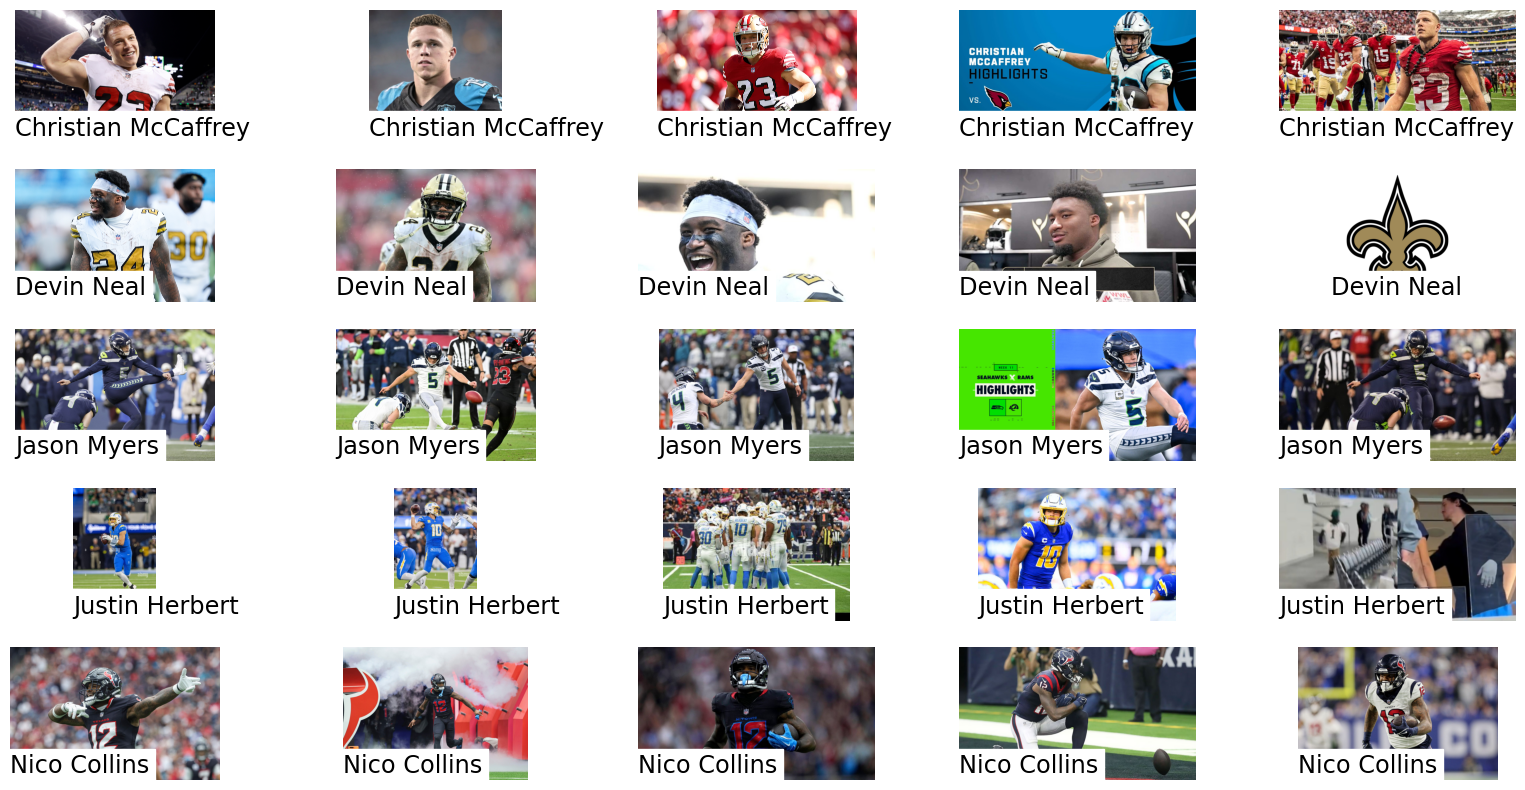

In [11]:
plt.figure(figsize=(20,10))
num_examples_per_class = 5
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

## Preparing Labels for Our Model's Config
By adding label2id + id2label to our model's config, we'll get friendlier labels in the inference API.

In [12]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

## Image Classification Collator
To apply our transforms to images, we'll use a custom collator class. We'll initialize it using an instance of ViTFeatureExtractor and pass the collator instance to torch.utils.data.DataLoader's collate_fn kwarg.

In [13]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings

In [14]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=4, collate_fn=collator, num_workers=0, shuffle=True)  # Smaller batch
val_loader = DataLoader(val_ds, batch_size=4, collate_fn=collator, num_workers=0)

C:\Users\benja\OneDrive\Documents\@DATA_5600\.newvenv\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training
Then I'll use PyTorch Lightning to fine-tune the model.

In [15]:
class Classifier(pl.LightningModule):
    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(
            task='multiclass' if model.config.num_labels > 2 else 'binary',
            num_classes=model.config.num_labels
        )
    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss
    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [16]:
import multiprocessing

pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
multiprocessing.set_start_method('spawn', force=True)
torch.set_num_threads(1)  # Limit CPU threads
trainer = pl.Trainer(accelerator='cpu', precision='16-mixed', max_epochs=4, log_every_n_steps=10)  # Mixed precision (faster/less mem), log more often
trainer.fit(classifier, train_loader, val_loader)

Seed set to 42
C:\Users\benja\OneDrive\Documents\@DATA_5600\.newvenv\Lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:479: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
C:\Users\benja\OneDrive\Documents\@DATA_5600\.newvenv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger

┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                      ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ ViTForImageClassification │ 85.8 M │ eval  │     0 │
│ 1 │ val_acc │ MulticlassAccuracy        │      0 │ train │     0 │
└───┴─────────┴───────────────────────────┴────────┴───────┴───────┘

Trainable params: 85.8 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 85.8 M                                                                                               
Total estimated model params size (MB): 343                                                                        
Modules in train mode: 1                                                                                           
Modules in eval mode: 214                                                                                          
Total FLOPs: 0

Output()

C:\Users\benja\OneDrive\Documents\@DATA_5600\.newvenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_c
onnector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the
value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

C:\Users\benja\OneDrive\Documents\@DATA_5600\.newvenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_c
onnector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing 
the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

C:\Users\benja\OneDrive\Documents\@DATA_5600\.newvenv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:534: 
Found 214 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If
this is intentional, you can ignore this warning.

C:\Users\benja\OneDrive\Documents\@DATA_5600\.newvenv\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette 
images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(

RuntimeError: bad allocation

In [ ]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

## Testing

In [ ]:
# Run full validation (computes avg loss/acc over all val batches)
trainer.validate(classifier, val_loader)

In [ ]:
from PIL import Image
import torch

test_image_paths = [
    'test_images/justin_herbert_test1.jpg',
    'test_images/nico_collins_test1.jpg',
    'test_images/christian_mccaffrey_test1.jpg',
    'test_images/devin_neal_test1.jpg',
    'test_images/jacob_myers_test1.jpg'
    # Add more here if necessary
]

model.eval()  # Eval mode

for img_path in test_image_paths:
    image = Image.open(img_path)
    # Preprocess (single image)
    inputs = feature_extractor(image, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    probs = outputs.logits.softmax(1)
    pred_idx = probs.argmax(1).item()
    pred_label = id2label[str(pred_idx)]
    confidence = probs[0][pred_idx].item()
    
    print(f"Image: {img_path}")
    print(f"Predicted: {pred_label} (Confidence: {confidence:.4f})")
    # Display image
    plt.imshow(image)
    plt.title(f"Pred: {pred_label}")
    plt.axis('off')
    plt.show()